In [56]:
import os
import csv
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [57]:
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [58]:
is_new_style = True

In [59]:
data_path='data'
root_path='data_grouped'
VALIDATION_SPLIT = 0.2
training_metadata = pd.read_csv(os.path.join(data_path,'Training_set.csv'))
if os.path.exists(root_path):
    shutil.rmtree(root_path)

os.mkdir(root_path)

if is_new_style:
    for _, row in training_metadata.iterrows():
        destination_path = os.path.join(root_path, row['label'])
        if not os.path.exists(destination_path):
            os.mkdir(destination_path)
        file_origin= os.path.join(data_path,'train',row['filename'])
        shutil.copy(file_origin,destination_path)
else:
    training_path = os.path.join(root_path,'training')
    testing_path = os.path.join(root_path,'testing')

    os.mkdir(training_path)
    os.mkdir(testing_path)

    df = training_metadata.sample(frac=1)
    train_size = len(df.index)*(1-VALIDATION_SPLIT)
    for index, row in df.iterrows():
        if index < train_size:
            file_path = training_path
        else:
            file_path = testing_path
        
        destination_path = os.path.join(file_path, row['label'])
        if not os.path.exists(destination_path):
            os.mkdir(destination_path)
        file_origin= os.path.join(data_path,'train',row['filename'])
        shutil.copy(file_origin,destination_path)


In [60]:
training_metadata.describe()

,filename,label
count,6499,6499
unique,6499,75
top,Image_1.jpg,MOURNING CLOAK
freq,1,131


In [61]:
training_metadata['label'].value_counts().describe()

count     75.000000
mean      86.653333
std        9.267049
min       71.000000
25%       81.000000
50%       86.000000
75%       92.000000
max      131.000000
Name: count, dtype: float64

In [62]:
training_metadata['label'].head()

0            SOUTHERN DOGFACE
1                      ADONIS
2              BROWN SIPROETA
3                     MONARCH
4    GREEN CELLED CATTLEHEART
Name: label, dtype: object

In [63]:
if not is_new_style:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_generator = train_datagen.flow_from_directory(
        training_path,
        batch_size=32,
        class_mode='sparse',
        target_size=(180, 180)
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        testing_path,
        batch_size=32,
        class_mode='sparse',
        target_size=(180, 180)
    )

    class_names = train_generator.class_indices
    num_classes = len(class_names)
    print("Number of classes: ",num_classes)


In [64]:
if is_new_style:
    training_processing = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2, fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    ])

    validation_processing = tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(scale=1./255),
    ])

    training_data, validation_data = tf.keras.preprocessing.image_dataset_from_directory(
        root_path,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(180, 180),
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        seed=1701,
        subset='both',
        interpolation='bilinear',
        verbose=True
    )

    class_names = training_data.class_names
    num_classes = len(class_names)
    print("Number of classes: ",num_classes)

    training_data = (
        training_data
        .map(lambda x, y: (training_processing(x), y),
            num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )

    validation_data = (
        validation_data
        .map(lambda x,y: (validation_processing(x), y),
            num_parallel_calls=tf.data.AUTOTUNE)
         .prefetch(tf.data.AUTOTUNE)
    )


Found 6499 files belonging to 75 classes.
Using 5200 files for training.
Using 1299 files for validation.
Number of classes:  75


In [65]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

if is_new_style:
    _train = training_data
    _validation = validation_data
else:
    _train = train_generator
    _validation = validation_generator

history = model.fit(
    _train,
    epochs=50,
    validation_data=_validation
)

Epoch 1/50


/home/cborys/miniconda3/envs/colin-tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.0106 - loss: 4.2939 - val_accuracy: 0.0377 - val_loss: 4.0439
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0353 - loss: 4.0692 - val_accuracy: 0.0600 - val_loss: 3.7933
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.0606 - loss: 3.8550 - val_accuracy: 0.1309 - val_loss: 3.4384
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.0913 - loss: 3.6039 - val_accuracy: 0.1747 - val_loss: 3.1014
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1311 - loss: 3.3912 - val_accuracy: 0.2102 - val_loss: 2.9356
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.1643 - loss: 3.1923 - val_accuracy: 0.2502 - val_loss: 2.7654
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.1804 - loss: 3.0765 - val_accuracy: 0.3133 - val_loss: 2.5711
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2089 - loss: 2.9681 - val_accuracy: 0.321

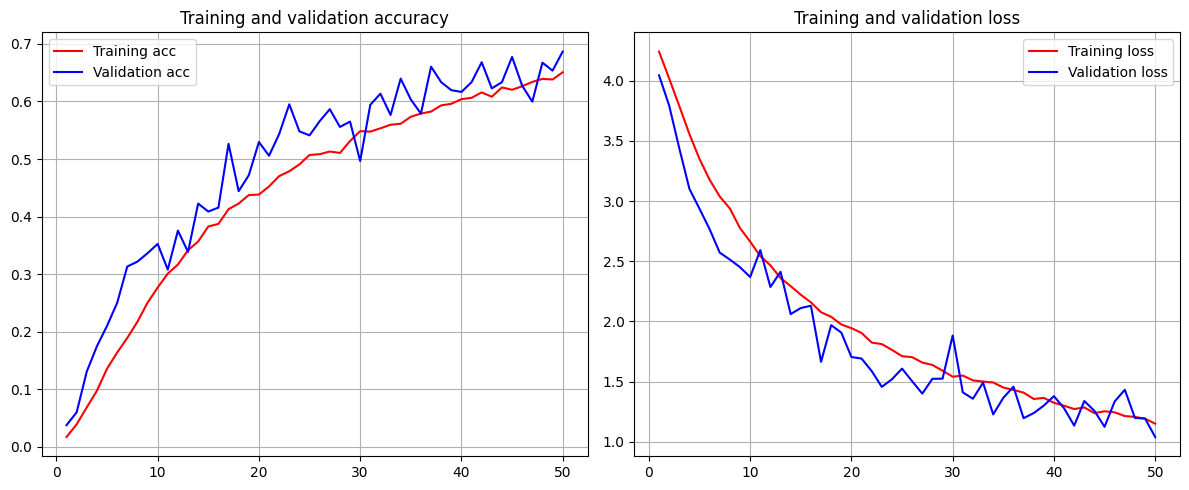

In [66]:
visualize(history)

In [67]:
"""
plt.figure(figsize=(10, 10))
for images, labels in validation_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
"""

'\nplt.figure(figsize=(10, 10))\nfor images, labels in validation_data.take(1):\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(images[i].numpy().astype("uint8"))\n    plt.title(class_names[labels[i]])\n    plt.axis("off")\n'